In [1]:
#import os
#import plaidml.keras
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from numpy import expand_dims
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
from pathlib import Path
from numpy import save
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from numpy import asarray
import shutil
import glob

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [3]:
traininglabels_df = pd.read_csv("traininglabels.csv") 
testlabels_df = pd.read_csv("testlabels.csv")

In [4]:
folder_train = 'train_images/'
folder_test = 'leaderboard_test_data/'

In [5]:
traininglabels_df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [6]:
df_class0 = traininglabels_df[traininglabels_df['has_oilpalm'] == 0]
df_class1 = traininglabels_df[traininglabels_df['has_oilpalm'] == 1]
df_class1_certain = traininglabels_df[traininglabels_df['has_oilpalm'] == 1][traininglabels_df['score'] == 1]
df_plot = pd.concat([df_class0, df_class1], axis=0)
df_class0.shape[0], df_class1.shape[0], df_class1_certain.shape[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(14302, 942, 768)

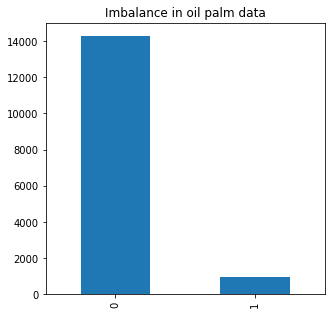

In [7]:
fig = plt.figure(figsize=(5,5))
df_plot['has_oilpalm'].value_counts().plot(kind='bar', title = 'Number of Images')
plt.title("Imbalance in oil palm data")
plt.show()

#### So I want to take the 768 images from df_class1_certain and create 13534 new images by rotating, filtering, etc to ultimately have balanced data.  That is, each of the 768 images should be rotated/filtered ~17 times and then appended to the class 1 training data.

In [8]:
df_class0.shape[0] - df_class1_certain.shape[0]

13534

In [9]:
p = Path('train_images_oversample')

def remove_folder(path):
    # check if folder exists
    if os.path.exists(path):
         # remove if exists
         shutil.rmtree(path)
        
remove_folder(p)
    
os.mkdir("train_images_oversample")
folder_new_train = 'train_images_oversample/'

In [10]:
df_class1_certain.reset_index(drop=True, inplace = True)

In [11]:
df_class1_certain['name'] = df_class1_certain['image_id'].str.replace('.jpg','')

In [12]:
df_class1_certain.head()

,image_id,has_oilpalm,score,name
0,img_001132017.jpg,1,1.0,img_001132017
1,img_002012017.jpg,1,1.0,img_002012017
2,img_002232017.jpg,1,1.0,img_002232017
3,img_002402017.jpg,1,1.0,img_002402017
4,img_002722017.jpg,1,1.0,img_002722017


In [13]:
img = load_img(folder_train + df_class1_certain['image_id'][75], target_size=(200, 200))

In [14]:
data = img_to_array(img)
samples = expand_dims(data, 0)

In [15]:
image_gen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

In [16]:
it = image_gen.flow(samples, batch_size=1)

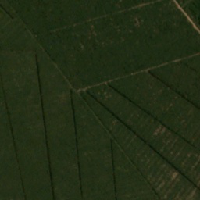

In [17]:
img

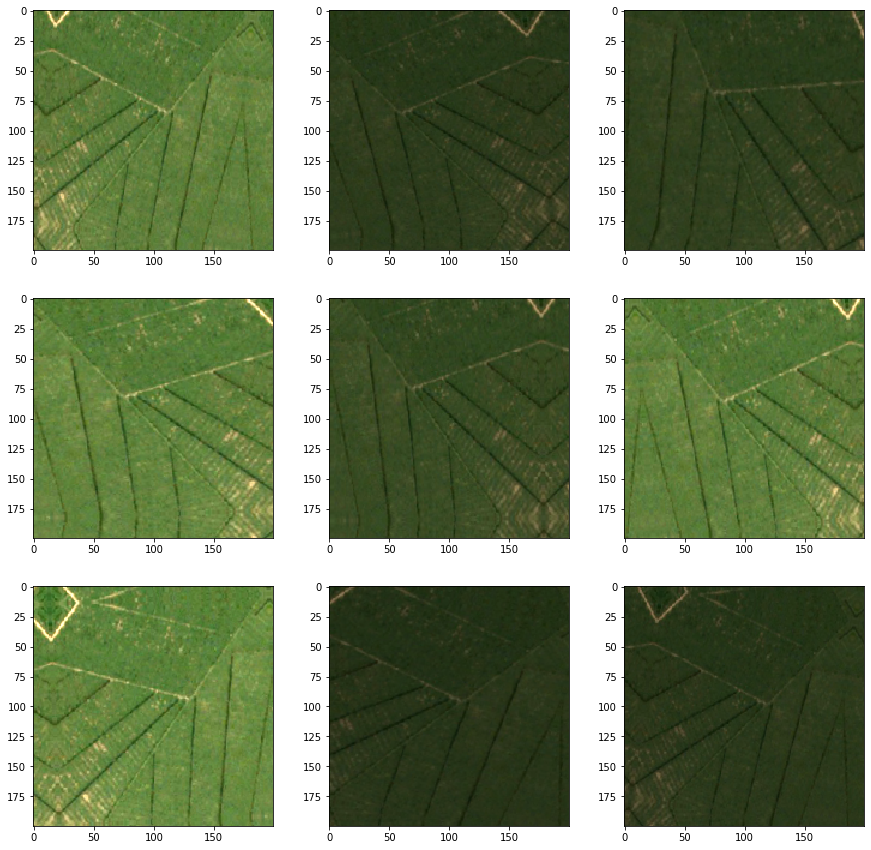

In [18]:
fig = plt.figure(figsize=(15,15))
for i in range(9):
    pyplot.subplot(331+i)
    batch = it.next()
    image = batch[0].astype('uint8')
    pyplot.imshow(image)

pyplot.show()


In [19]:
def transformdata(df_in, name, trainortest):
    #reset the dataframe in case its discontinuous and randomize the data
    df_in.sample(frac=1).reset_index(drop=True, inplace=True)
    photo_list = []
    
    if(trainortest == 'train'):
        folder = folder_train
    elif(trainortest == 'test'):
        folder = folder_test
    else:
        return
    
    for i in range(df_in.shape[0]):
        #load image
        photo = load_img(folder + df_in['image_id'][i], target_size=(200, 200))
        #convert to np array and store
        photo_list.append(img_to_array(photo))
    
    #create the labels also
    label_list = df_in['has_oilpalm'].tolist()
    #convert to numpy array for the model
    photos = asarray(photo_list)
    labels = asarray(label_list)
    #save a copy so i can access the data later
    save(name +'_images.npy', photos)
    save(name +'_labeles.npy', labels)
    #print the shape of the image, label data
    print(photos.shape, labels.shape)
    return photos, labels

In [20]:
image_train_class1, label_train_class1 = transformdata(df_class1_certain, "Class1_train", 'train')

(768, 200, 200, 3) (768,)


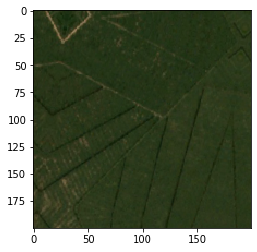

In [21]:
pyplot.imshow(image)

In [22]:
save_img(folder_new_train+'image1.png', image)

#### Now lets generate images on the class1 data

In [23]:
def getoversampled(image, num_to_generate, name):

    #data = image_train_class1[0]
    samples = expand_dims(image, 0)
    it = image_gen.flow(samples, batch_size=1)
    
    for i in range(num_to_generate):
        batch = it.next()
        image = batch[0].astype('uint8')
        save_img(folder_new_train + name + '_'+ str(i) +'.jpg', image)
        

In [24]:
df_class1_certain.head()

,image_id,has_oilpalm,score,name
0,img_001132017.jpg,1,1.0,img_001132017
1,img_002012017.jpg,1,1.0,img_002012017
2,img_002232017.jpg,1,1.0,img_002232017
3,img_002402017.jpg,1,1.0,img_002402017
4,img_002722017.jpg,1,1.0,img_002722017


In [25]:
getoversampled(image_train_class1[0], 16, df_class1_certain['name'][0])

In [26]:
df_class1_certain.shape[0]

768

In [27]:
for i in range(df_class1_certain.shape[0]):
    getoversampled(image_train_class1[i], 17, df_class1_certain['name'][i])

In [28]:
oversampled_train_class1 = pd.DataFrame(glob.glob(folder_new_train+"*.jpg"))

In [29]:
oversampled_train_class1.rename(columns={0: "image_id"}, inplace=True)
oversampled_train_class1['has_oilpalm'] = 1

In [30]:
oversampled_train_class1.head()

,image_id,has_oilpalm
0,train_images_oversample/img_028432017_12.jpg,1
1,train_images_oversample/img_013652018_7.jpg,1
2,train_images_oversample/img_059892018_6.jpg,1
3,train_images_oversample/img_091692018_6.jpg,1
4,train_images_oversample/img_103852018_3.jpg,1


In [31]:
traininglabels_df['oversampled'] = 0
oversampled_train_class1['oversampled'] = 1
df_train = pd.concat([traininglabels_df, oversampled_train_class1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
df_train.head()

,has_oilpalm,image_id,oversampled,score
0,0,img_000002017.jpg,0,0.7895
1,0,img_000012017.jpg,0,1.0000
2,0,img_000022017.jpg,0,1.0000
3,0,img_000072017.jpg,0,1.0000
4,0,img_000082017.jpg,0,1.0000


In [33]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,has_oilpalm,image_id,oversampled,score
0,0,img_048952018.jpg,0,1.0
1,0,img_082322017.jpg,0,1.0
2,1,train_images_oversample/img_082152018_8.jpg,1,NaN
3,0,img_057072018.jpg,0,1.0
4,1,train_images_oversample/img_074792018_6.jpg,1,NaN


In [34]:
df_train['oversampled'][i]==1

True

In [35]:
def getoverloadeddata(df_in, name):
    #reset the dataframe in case its discontinuous and randomize the data
    df_in.sample(frac=1).reset_index(drop=True, inplace=True)
    photo_list = []
    
    for i in range(df_in.shape[0]):
        #if created by imagegenerator
        if(df_in['oversampled'][i] == 1):
            photo = load_img( df_in['image_id'][i], target_size=(200, 200))
        #if part of the orig train data set
        else:
            photo = load_img(folder_train + df_in['image_id'][i], target_size=(200, 200))
        
        #convert to np array and store
        photo_list.append(img_to_array(photo))
    
    #create the labels also
    label_list = df_in['has_oilpalm'].tolist()

    #convert to numpy array for the model
    photos = asarray(photo_list)
    labels = asarray(label_list)
    #save a copy so i can access the data later
    save(name +'_images.npy', photos)
    save(name +'_labeles.npy', labels)
    #print the shape of the image, label data
    print(photos.shape, labels.shape)
    return photos, labels

In [36]:
image_over_train, label_over_train = getoverloadeddata(df_train, 'overloaded_train')

(28300, 200, 200, 3) (28300,)


In [37]:
image_test, label_test = transformdata(testlabels_df, 'test', 'test')

(4356, 200, 200, 3) (4356,)
